# Load the required package


In [1]:
import random
import scipy.misc
import csv
import numpy as np
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.contrib.learn as skflow

from numpy import float32
from numpy import uint8
from numpy import int64
from PIL import Image
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

# Read mammogram test and training data

In [2]:
def readTrainTest():
    num_images = 201
    img_length = 50
    #read image pixel vals in
    fileName = "./data/raw_data/UPNG/mdb"
    train_mgrams = []
    test_mgrams = []

    for i in range(1,num_images):
        if i < 100:
            if i < 10:
                fname = fileName + "00" + str(i) + ".png"
            else:
                fname = fileName + "0" + str(i) + ".png"
        else:
            name = fileName + str(i) + ".png"

        im = Image.open(fname).load() 

        center = random.randrange(482,542)

        pixels = [im[k,j] for k in range(center-img_length, center + img_length) 
                  for j in range(center - img_length, center +img_length)]

        if i < num_images - 100:
            train_mgrams.append(pixels)
        else:
            test_mgrams.append(pixels)

    training_data = np.ndarray(shape=(num_images - 1 - 50,100*100), buffer=np.array(train_mgrams), dtype=float32)
    testing_data = np.ndarray(shape=(100,100*100), buffer=np.array(test_mgrams), dtype=float32)

    #read label data and convert as one hot conversion
    f=open("./data/labels.csv")
    labels = []
    for row in csv.reader(f, delimiter=' '):
        #N, B, M
        if row[3] == "N":
            #labels.append([1,0,0])
            labels.append(0)
        elif row[3] == "B":
            #labels.append([0,1,0])
            labels.append(1)
        else:
            #labels.append([0,0,1])
            labels.append(2)

    del labels[num_images:]
    training_labels = np.ndarray(shape=(num_images - 1 - 100,), buffer=np.array(labels[:num_images - 50]), dtype=int64)
    testing_labels = np.ndarray(shape=(100,), buffer=np.array(labels[num_images - 100:]), dtype=int64)
    print('No of training images ',len(train_mgrams))
    print('No of training labels ',len(training_labels))
    print('Training dataset pixel size',len(train_mgrams[0]))

    print('No of test set images ',len(test_mgrams))
    print('No of test set labels ',len(testing_labels))
    print('Test dataset pixel size',len(test_mgrams[0]))
    return  (test_mgrams,training_data, testing_data, training_labels, testing_labels)

In [3]:
# Load mammogram data
test_number = 2#Set is as default one

print("Loading in Mammogram data...")
train_mgrams,training_data, testing_data, training_labels, testing_labels=readTrainTest()
print("Mammogram data loaded.\n")

### GLOBAL CONSTANTS

POOLING_X_DIM = 2
POOLING_Y_DIM = 2
IMAGE_X_DIM = 48
IMAGE_Y_DIM = 48
FEATURES_LAYER_1 = 32
FEATURES_LAYER_2 = 64
KERNEL_LAYER_1 = 5
KERNEL_LAYER_2 = 5
NUM_LAYERS = 2
NUM_FOLDS = 8
if test_number == 2:
    NUM_CLASSES = 3
else:
    NUM_CLASSES = 2
NUM_STEPS = 10000
LEARN_RATE = .003

Loading in Mammogram data...
No of training images  100
No of training labels  100
Training dataset pixel size 10000
No of test set images  100
No of test set labels  100
Test dataset pixel size 10000
Mammogram data loaded.



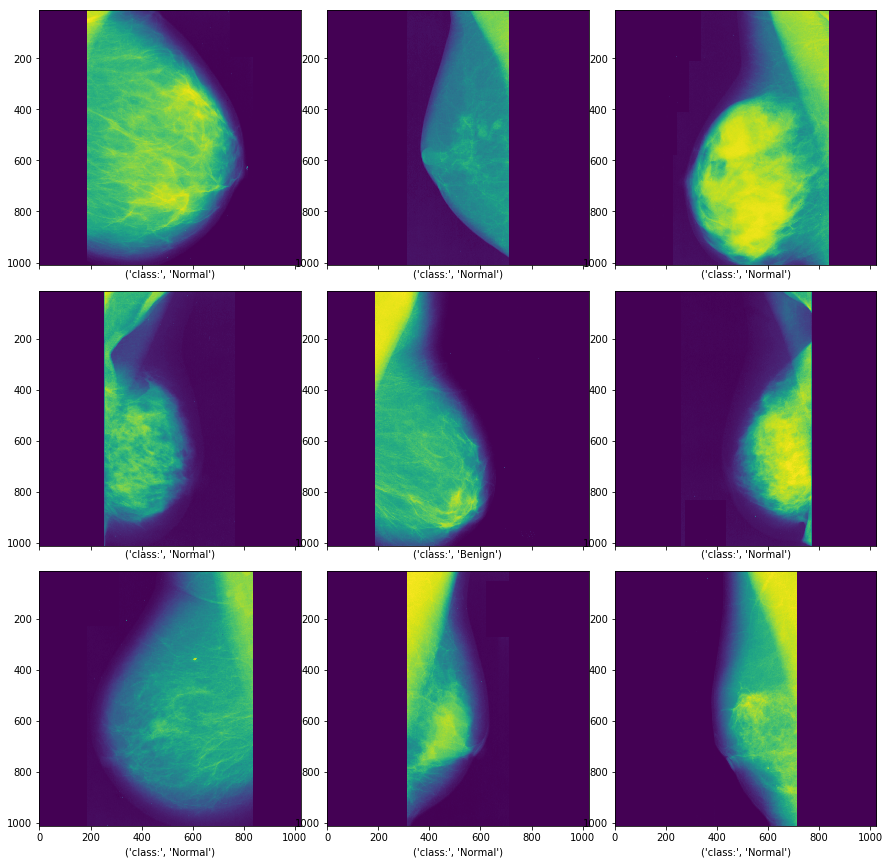

In [4]:
#read image pixel vals in
fileName = "./data/raw_data/UPNG/mdb"
# Display nine image which is selected randomly
random_indices = random.sample(range(len(train_mgrams)), min(len(train_mgrams), 9))
plot,axes = plt.subplots(3,3,figsize = (15,15), sharex=True)
ind=0
for i in random_indices:
    r = ind % 3 # Get subplot row
    c = ind // 3 # Get subplot column
    if i < 100:
        if i < 10:
            fname = fileName + "00" + str(i) + ".png"
        else:
            fname = fileName + "0" + str(i) + ".png"
    else:
        name = fileName + str(i) + ".png"

    im = Image.open(fname).load() 
    
    # Show true and predicted classes.
    if training_labels[i] ==0:
        label = "Normal"
    elif training_labels[i] ==1:
        label = 'Benign'
    else:
        label = 'Malignant'
    axes[r, c].set_xlabel(('class:',label))
    axes[r, c].imshow(mpimg.imread(fname))        
  
    ind+=1

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


In [5]:
"""
Prepare kfold training data splits
"""

folds = 10
print("Performing ", folds, "-fold validation")

skf = StratifiedKFold(n_splits=NUM_FOLDS)
train_data    = []
test_data     = []
train_labels  = []
test_labels   = []
i = 0
delta = -1
for train_indices, test_indices in skf.split(training_labels, testing_labels):
    print("Train len: ", len(train_indices), "Test len: ", len(test_indices))
    
    train_batch = np.array([training_data[i] for i in train_indices])
    train_label = np.array([training_labels[i] for i in train_indices])
    test_batch = np.array([testing_data[i] for i in test_indices])
    test_label = np.array([testing_labels[i] for i in test_indices])
    
    train_data.append(np.ndarray(shape=(len(train_indices),IMAGE_X_DIM*IMAGE_Y_DIM), dtype=float32))
    train_labels.append(np.ndarray(shape=(len(train_indices),), dtype=uint8))
    test_data.append(np.ndarray(shape=(len(test_indices),IMAGE_X_DIM*IMAGE_Y_DIM), dtype=float32))
    test_labels.append(np.ndarray(shape=(len(test_indices),), dtype=uint8))
    if NUM_CLASSES == 3:
        delta = 0
        
    for j in range(len(train_indices)):
        train_labels[i][j] = train_label[j] + delta
        train_data[i][j] = train_batch[i][j]
    for j in range(len(test_indices)):
        test_labels[i][j] = test_label[j] + delta
        test_data[i][j]   = test_batch[i][j]
    i += 1

print(folds, "-fold validation prepared.\n")


Performing  10 -fold validation
Train len:  87 Test len:  13
Train len:  87 Test len:  13
Train len:  87 Test len:  13
Train len:  87 Test len:  13
Train len:  87 Test len:  13
Train len:  87 Test len:  13
Train len:  88 Test len:  12
Train len:  90 Test len:  10
10 -fold validation prepared.



In [10]:
"""
Convolutional Network Model

"""
### Convolutional network
##############################################################################
def max_pool_2x2(tensor_in):
    return tf.nn.max_pool(tensor_in, ksize=[1, POOLING_X_DIM, POOLING_Y_DIM, 1], strides=[1, POOLING_X_DIM, POOLING_Y_DIM, 1],
        padding='SAME')

def conv_model(X, y):
    print(len(X),len(y))
    # reshape X to 4d tensor with 2nd and 3rd dimensions being image width and height
    # final dimension being the number of color channels
    X = tf.reshape(X, [-1, IMAGE_X_DIM, IMAGE_Y_DIM, 1])
    # first conv layer will compute 32 features for each 5x5 patch
    with tf.variable_scope('conv_layer1'):
        h_conv1 = skflow.ops.conv2d(X, n_filters=FEATURES_LAYER_1, filter_shape=[KERNEL_LAYER_1, KERNEL_LAYER_1],
                                    bias=True, activation=tf.nn.relu)
        h_pool1 = max_pool_2x2(h_conv1)
    # second conv layer will compute 64 features for each 5x5 patch
    with tf.variable_scope('conv_layer2'):
        h_conv2 = skflow.ops.conv2d(h_pool1, n_filters=FEATURES_LAYER_2, filter_shape=[KERNEL_LAYER_2, KERNEL_LAYER_2],
                                    bias=True, activation=tf.nn.relu)
        h_pool2 = max_pool_2x2(h_conv2)
        # reshape tensor into a batch of vectors
        # 25 * 25 after max pooling twice
        h_pool2_flat = tf.reshape(h_pool2, [-1, 12 * 12 * 64])
        #DNN with 1024 hidden layers, and dropout of 0.5 probability.
        h_fc1 = skflow.ops.dnn(h_pool2_flat, [1024], activation=tf.nn.relu, keep_prob=0.5)
        #  """DNN with 64,128,64 hidden layers, and dropout of 0.5 probability."""
        # h_fc1 = skflow.ops.dnn(h_pool2_flat, [64,128,64], activation=tf.nn.relu, keep_prob=0.5)

    return skflow.models.logistic_regression(h_fc1, y) #softmax?

"""
Train and test model
"""
classifier = skflow.Estimator( model_fn=conv_model)

print("Training convolutional NN with ", NUM_STEPS, " steps with ", LEARN_RATE, " learning rate.")
i = 0

classifier.fit(train_data[i], train_labels[i])
print("Fitted data")
results = classifier.predict(test_data[i])
print("Expected labels:                 (0 = Normal, 1 = Benign, 2 = Cancerous)")
print(test_labels[i])
print("\nPredicted labels:")
print(results)

# Training Accuracy (check for overfitting)
training_results = classifier.predict(train_data[i])
training_accuracy = metrics.accuracy_score(train_labels[i], training_results)
print("\nTraining Predicted labels:")
print(training_results, "\n")
# Accuracy
accuracy = metrics.accuracy_score(test_labels[i], results)
print("Printing metrics ================")
print('Accuracy          : {0:f}'.format(accuracy))
print('Training Accuracy : {0:f}'.format(training_accuracy))
# Precision
precision = metrics.precision_score(test_labels[i], results, labels=[2]) #only calculate for malignant case
print('Precision         : {0:f}'.format(precision))
# Recall ***
recall = metrics.recall_score(test_labels[i], results, labels=[2])       #only calculate for malignant case
print('Recall            : {0:f}'.format(recall))
f1_score = metrics.f1_score(test_labels[i], results, labels=[2])
print('F1 Score          : {0:f}'.format(f1_score))
print("Finished.\n")

# summary_op = tf.merge_all_summaries()
# summary_writer = tf.train.SummaryWriter("test/")
# summary_str = sess.run(summary_op, feed_dict=feed_dict)
# summary_writer.add_summary(summary_str, step)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1201e5390>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/var/folders/b9/shtfm7g92w1gvn8vv066v5k80000gn/T/tmp41r7spdm'}
Training convolutional NN with  10000  steps with  0.003  learning rate.
[[  1.80767502e-43   1.80767502e-43   1.80767502e-43 ...,   1.80767502e-43
    1.80767502e-43   1.80767502e-43]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0

TypeError: object of type 'Tensor' has no len()